In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.6 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout

import seaborn as sns

from glob import glob
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [9]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')

In [10]:
def get_duration(file):

    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    time = librosa.get_duration(y=audio, sr=sample_rate)

    return time

In [11]:
duration = []

for index_num, row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    time = get_duration(file_name)

    duration.append(time)

3480it [24:38,  2.35it/s]


In [12]:
df['duration'] = duration
sorted_df = df[df.duration <= 3]
sorted_df['class'].value_counts()

Grunt    1491
Roar      993
IRoar     987
Name: class, dtype: int64

In [13]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [14]:
appended = []
for i in range(1,4):
    appended.append(sorted_df[sorted_df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,332,326
1,fold2,496,329,329
2,fold3,499,332,332


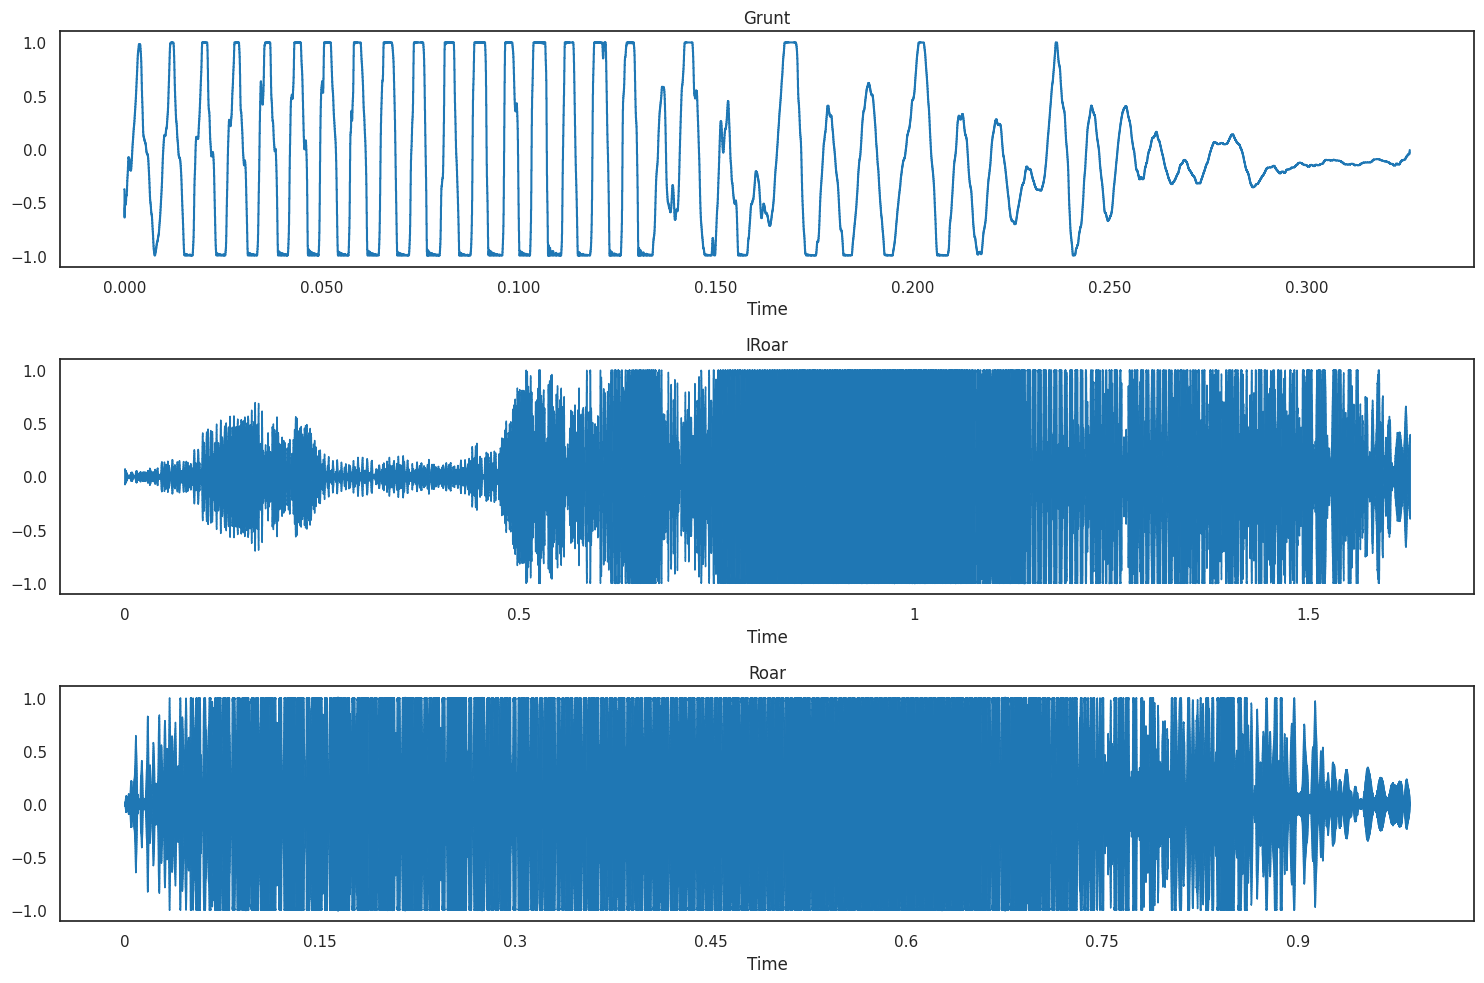

In [15]:
# Randomly select one sample of each class
random_samples = sorted_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

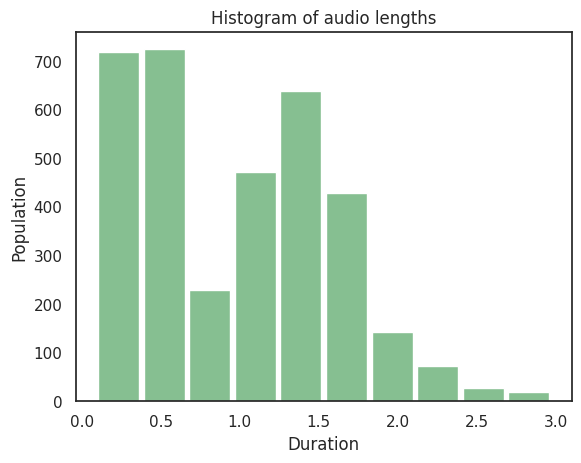

Greater than 3 seconds: 0
Lower than 3 but greater than 2 seconds: 152
Lower than 2 but greater than 1 seconds: 1601
Lower than 1 seconds: 1718


In [16]:
plt.hist(sorted_df['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

# Count samples with duration > 3 sec
gt_3sec = sorted_df['duration'][(sorted_df['duration'] > 3)].count()
gt_2sec = sorted_df['duration'][(sorted_df['duration'] > 2) & (sorted_df['duration'] < 3)].count()
lt_2sec = sorted_df['duration'][(sorted_df['duration'] > 1) & (sorted_df['duration'] < 2)].count()
lt_1sec = sorted_df['duration'][sorted_df['duration'] < 1].count()

# Display counts of interest
print("Greater than 3 seconds: {}".format(gt_3sec))
print("Lower than 3 but greater than 2 seconds: {}".format(gt_2sec))
print("Lower than 2 but greater than 1 seconds: {}".format(lt_2sec))
print("Lower than 1 seconds: {}".format(lt_1sec))

In [17]:
# Feature extraction using librosa

def features_extract(file):
    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    #trim the audio file
    audio_trimmed, _ = librosa.effects.trim(audio)

    # extract the features
    feature = librosa.feature.mfcc(y=audio_trimmed[0:2000],sr=sample_rate,n_mfcc=40)
    feature_norm = (feature - feature.mean())/feature.std()

    # feature scaling
    scaled_feature = np.mean(feature_norm.T,axis=0)

    # return the scaled features
    return scaled_feature

# list containg all the features
extracted = []

# for each row in the csv
for index_num,row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    # get file label
    final_class_labels = row['class']

    # extract feature
    data= features_extract(file_name)

    # store it in a list
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2000
  warnings.warn(
177it [00:07, 31.04it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1999
  warnings.warn(
3480it [02:05, 27.76it/s]


In [18]:
df_extracted = pd.DataFrame(extracted,columns=['feature','label'])

# Adding 'fold' column to new DataFrame which contains extracted feature and label
df_extracted['fold'] = df['fold']
df_extracted.head()

,feature,label,fold
0,"[-5.265633, 3.0062795, 0.27746803, 0.5316999, ...",IRoar,1
1,"[-3.359255, 4.9827685, -0.34542045, 0.60487145...",IRoar,1
2,"[-4.615505, 3.8425388, 0.5594614, 0.6401226, 0...",Grunt,2
3,"[-4.8669667, 3.2608159, 0.322846, 0.73293835, ...",Roar,1
4,"[-4.0004916, 4.5910044, 0.46676683, 0.5683199,...",Roar,3


In [19]:
le = LabelEncoder()
y = np.array(df_extracted.label.tolist())

filter_size = 3
y = np_utils.to_categorical(le.fit_transform(y))

num_labels = y.shape[1]

# build model
model = Sequential()
model.add(Dense(512, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               20992     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [20]:
predicted = []
actual = []

# Taking 1 fold for Validation and rest 9 folds for train sets.
# Using for loop so that each fold becomes validation set once and rest 9 as train set.

for i in range(1,4):
    validation_data = df_extracted[df_extracted['fold'] == i]
    train_data = df_extracted[df_extracted['fold'] != i]

    x = np.array(train_data.feature.tolist())
    y = np.array(train_data.label.tolist())

    x_val = np.array(validation_data.feature.tolist())
    y_val = np.array(validation_data.label.tolist())

    y = np_utils.to_categorical(le.fit_transform(y))
    y_val = np_utils.to_categorical(le.fit_transform(y_val))

    fitting = model.fit(x, y, batch_size=64, epochs=10, validation_data=(x_val, y_val), shuffle=False)
    pred = model.predict(x_val)

    predicted.append(pred)
    actual.append(y_val)

Epoch 1/10
37/37 [==============================] - 2s 25ms/step - loss: 0.9100 - accuracy: 0.5771 - val_loss: 0.8001 - val_accuracy: 0.6399
Epoch 2/10
37/37 [==============================] - 1s 27ms/step - loss: 0.7393 - accuracy: 0.6813 - val_loss: 0.7938 - val_accuracy: 0.6485
Epoch 3/10
37/37 [==============================] - 1s 20ms/step - loss: 0.6689 - accuracy: 0.7123 - val_loss: 0.7561 - val_accuracy: 0.6546
Epoch 4/10
37/37 [==============================] - 1s 31ms/step - loss: 0.6329 - accuracy: 0.7399 - val_loss: 0.7285 - val_accuracy: 0.6693
Epoch 5/10
37/37 [==============================] - 1s 26ms/step - loss: 0.6097 - accuracy: 0.7450 - val_loss: 0.7261 - val_accuracy: 0.6753
Epoch 6/10
37/37 [==============================] - 1s 28ms/step - loss: 0.5957 - accuracy: 0.7515 - val_loss: 0.7374 - val_accuracy: 0.6684
Epoch 7/10
37/37 [==============================] - 1s 32ms/step - loss: 0.5833 - accuracy: 0.7580 - val_loss: 0.7224 - val_accuracy: 0.6736
Epoch 8/10
37

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
acc = []
for i in range(0,3):
    predict_conv = np.argmax(predicted[i],axis=1)
    actual_conv = np.argmax(actual[i],axis=1)
    acc.append(accuracy_score(actual_conv,predict_conv))
print("Accuracy for 3 fold cross validation:",np.mean(acc))

Accuracy for 3 fold cross validation: 0.7298188019222059


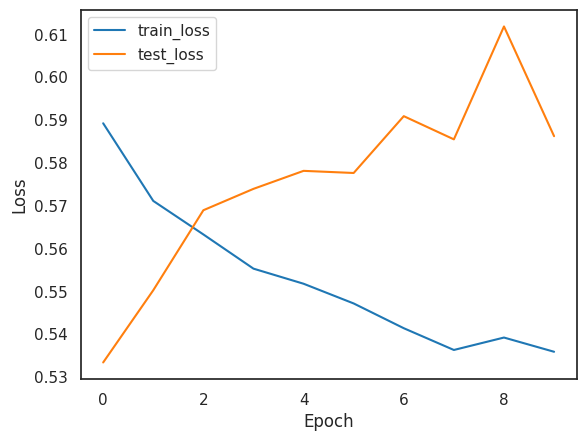

In [23]:
# Plotting ANN Loss

metrics = fitting.history
plt.plot(fitting.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

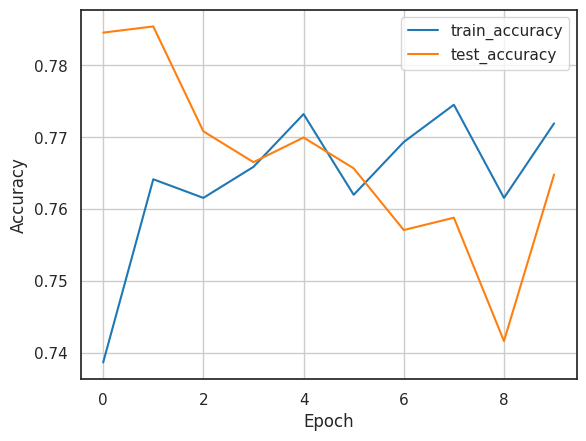

In [24]:
# Plotting ANN Accuracy

plt.plot(fitting.history['accuracy'], label='train_accuracy')
plt.plot(fitting.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)